In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

##################  Загрузка данных
Xtrain = pd.read_csv('D:\Coding\data\phone_user_review_file_60.csv', encoding= 'utf-8')
Xtest = pd.read_csv('D:\Coding\data\phone_user_review_file_40.csv', encoding= 'utf-8')

In [2]:
print("Xtrain.shape(): ", Xtrain.shape,
      "\nXtest.shape(): ", Xtest.shape)

Xtrain.shape():  (163837, 11) 
Xtest.shape():  (98284, 11)


In [3]:
print("Xtrain.head():\n", Xtrain[['lang', 'score', 'extract']].head())

Xtrain.head():
   lang  score                                            extract
0   en    8.0  I've had the phone for awhile and it's a prett...
1   en    6.0  to be clear it is not the sellers fault that t...
2   en    9.0  Well i love this phone. i have had ton of phon...
3   en    4.0  I have had my Instinct for several months now ...
4   en    6.0  i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
# Преобразуем время
# Разделение времени на год и месяц
Xtrain['date'] = Xtrain['date'].apply(pd.to_datetime)
Xtrain['year'] = Xtrain['date'].apply(lambda x: x.year)
Xtrain['month'] = Xtrain['date'].apply(lambda x: x.month)

In [8]:
#Валидация на 2016 годе
Xtr = Xtrain[(Xtrain['year']==2015) & (Xtrain.lang == 'en')].head(200)
Xval = Xtrain[(Xtrain['year']==2016) & (Xtrain.lang == 'en')].head(50)
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [9]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 13) 
Xval.shape():  (50, 13) 
ytr.mean():  7.925 
yval.mean():  8.22


In [10]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [11]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['price', 'expected', 'phone', 'beat', 'work']


############## Word2vec ##############

In [12]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

#model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())


######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [13]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [14]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(250, 300)

In [15]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y,200)

In [16]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 300) 
Xval.shape():  (50, 300) 
ytr.mean():  7.925 
yval.mean():  8.22


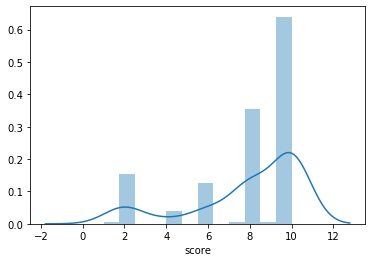

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############## Linear Regression ##############

In [18]:
from sklearn.linear_model import LinearRegression

linear_regression_01 = LinearRegression()
model = linear_regression_01.fit(Xtr, ytr)

predicted_Xtr = model.predict(Xtr)
predicted_Xval = model.predict(Xval)

print("\nПредсказанные моделью значения:\n", predicted_Xtr[:10])


Предсказанные моделью значения:
 [ 4.000001   6.0000095 10.000005   1.9999981 10.000003   8.000003
  9.999993   8.         9.999994   5.999997 ]


In [19]:
predicted_truth_df = pd.DataFrame(list(zip(predicted_Xtr, ytr)))
predicted_truth_df.columns = ['Prediction', 'Ground truth']
print(predicted_truth_df.head())

   Prediction  Ground truth
0    4.000001           4.0
1    6.000010           6.0
2   10.000005          10.0
3    1.999998           2.0
4   10.000003          10.0


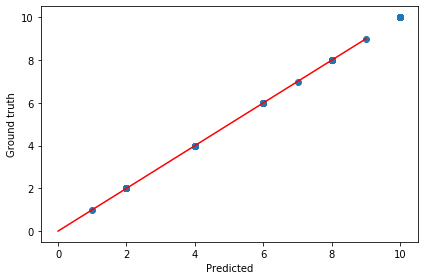

In [22]:
########## Scatter plot трейна (оценка модели)

plt.figure(figsize=(6, 4))
plt.scatter(predicted_Xtr, ytr)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.plot([0, 9], [0, 9], color = "red")
plt.tight_layout()
plt.show()

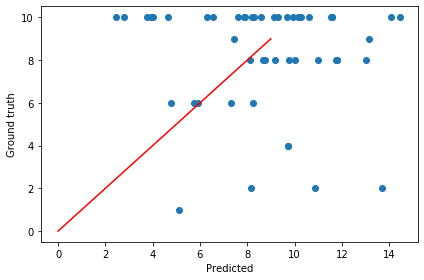

In [23]:
########## Scatter plot валидация (оценка модели)

plt.figure(figsize=(6, 4))
plt.scatter(predicted_Xval, yval)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.plot([0, 9], [0, 9], color = "red")
plt.tight_layout()
plt.show()